In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
class RandomWeightedGraph(nx.Graph):
    def __init__(self, nodes:int):
        super().__init__(nx.bipartite.random_graph(nodes, nodes, 0.5).edges())
        for (u, v) in self.edges():
            self.edges[u,v]['weight'] = np.random.randint(10, 100)
            
    def weight(self, edge):
        return self.edges[edge]['weight']

In [20]:
class MinimumSpanningTree(dict):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        self._original_G, self._G, self._root = G.copy(), G, root
        if describe:
            self._setup_describe()

    def _setup_describe(self):
        #self._pos = nx.kamada_kawai_layout(self._G)
        self._pos = nx.spring_layout(self._G, iterations=10000)
        gray, self._dark_gray = '#eeeeee', '#555555'
        self._node_colors = [gray for n in self._G]
        self._edge_colors = [gray for e in self._G.edges]
        positions = np.array(list(self._pos.values()))
        self._min_x, self._min_y = np.min(positions, axis=0) - 0.1
        self._max_x, self._max_y = np.max(positions, axis=0) + 0.1

    def _plot_graphs(self, graphs: list, title: str):
        n, graph_size, graph_per_row = len(graphs), 7, 4
        w, h = min(n, graph_per_row), np.ceil(n / graph_per_row)
        plt.figure(figsize=(graph_size * w, graph_size * h))
        plt.suptitle(title)
        for i, (G, colors, title) in enumerate(graphs):
            ax = plt.subplot(h, w, i + 1)
            ax.set_xlim(self._min_x, self._max_x)
            ax.set_ylim(self._min_y, self._max_y)
            ax.set_title(title)
            nx.draw(
                self._original_G,
                pos=self._pos,
                with_labels=True,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'),
                node_color=self._node_colors,
                edge_color=self._edge_colors)
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=colors,
                edge_color=colors)
            nx.draw_networkx_edge_labels(
                self._original_G,
                pos=self._pos,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'))

        legend = {
            "Tree": "r",
            "Unexplored": "c",
            "Current node": "m",
            "Unexplored neighbours": "g"
        }

        plt.margins(0.5, 0.1)
        plt.legend(
            [Line2D([0], [0], color=color, lw=4) for color in legend.values()],
            legend.keys(),
            loc='center right',
            bbox_to_anchor=(2, 0.5))
        plt.show()

    def _describe_start(self, root: int):
        tree = nx.Graph()
        tree.add_node(root)
        colors = ['r' for n in self._original_G]
        self._plot_graphs([(self._original_G, colors, "Initial Graph"),
                           (tree, colors, "Initial Tree")],
                          "Initial Conditions")

In [24]:
class PrimTree(MinimumSpanningTree):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        super().__init__(G, root, describe=describe)
        costs = dict((v, np.inf) if v != root else (v, 0) for v in G)
        i = 0
        pred = {root:root}
        while costs and not self._is_spanning():
            if describe:
                print("Current costs: {queue}".format(queue=costs))
            node = min(costs, key=costs.get)
            self[node] = pred[node]
            costs.pop(node, None)
            neighbors = []
            for v in G.neighbors(node):
                if v in costs and G.weight((node, v)) < costs[v]:
                    pred[v] = node
                    neighbors.append(v)
                    costs[v] = G.weight((node, v))
            if describe:
                self._plot_graphs(
                    [(*self._create_iteration_graph(costs, neighbors, node),
                      "Current step"), (nx.Graph(list(self.items())),
                                        ['r' for n in self], "Current Tree")],
                    "Iteration {i}: adding node {node}.".format(i=i, node=node))
            i += 1

    def _is_spanning(self):
        """Determine if tree is currently spanning the graph G."""
        return len({v for g in zip(*self.items()) for v in g}) == len(self._G)

    def _create_iteration_graph(self, costs: dict, neighbors: list,
                                node: int) -> tuple:
        iteration = nx.Graph()
        [iteration.add_node(v) for v in [*costs, node, *neighbors]]
        colors = [
            'g' if v in neighbors else 'm' if v == node else 'c'
            for v in iteration
        ]
        return iteration, colors

In [25]:
random.seed(32)
np.random.seed(23)
G = RandomWeightedGraph(6)
root = 1
end = 4

Current costs: {0: inf, 6: inf, 7: inf, 8: inf, 1: 0, 9: inf, 10: inf, 2: inf, 11: inf, 3: inf, 4: inf, 5: inf}


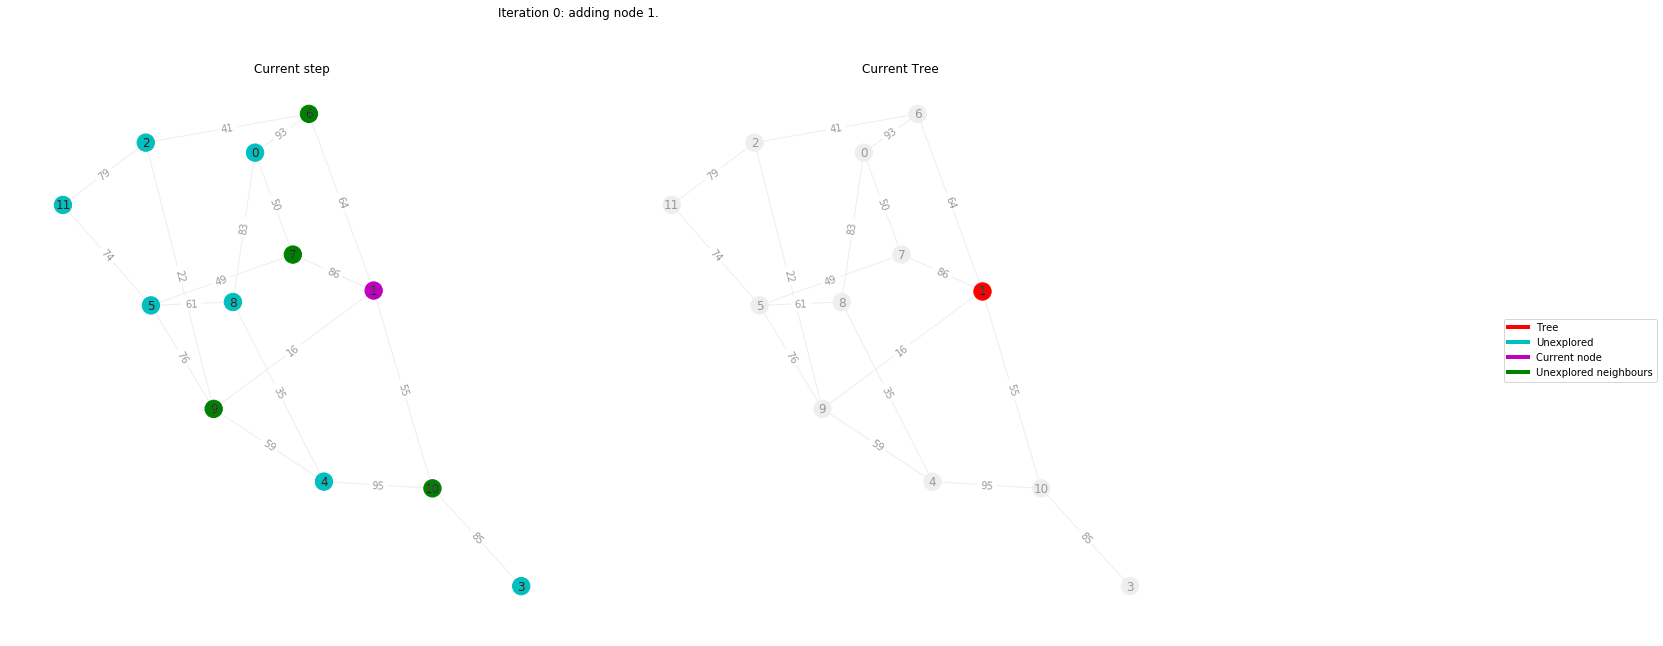

Current costs: {0: inf, 6: 64, 7: 86, 8: inf, 9: 16, 10: 55, 2: inf, 11: inf, 3: inf, 4: inf, 5: inf}


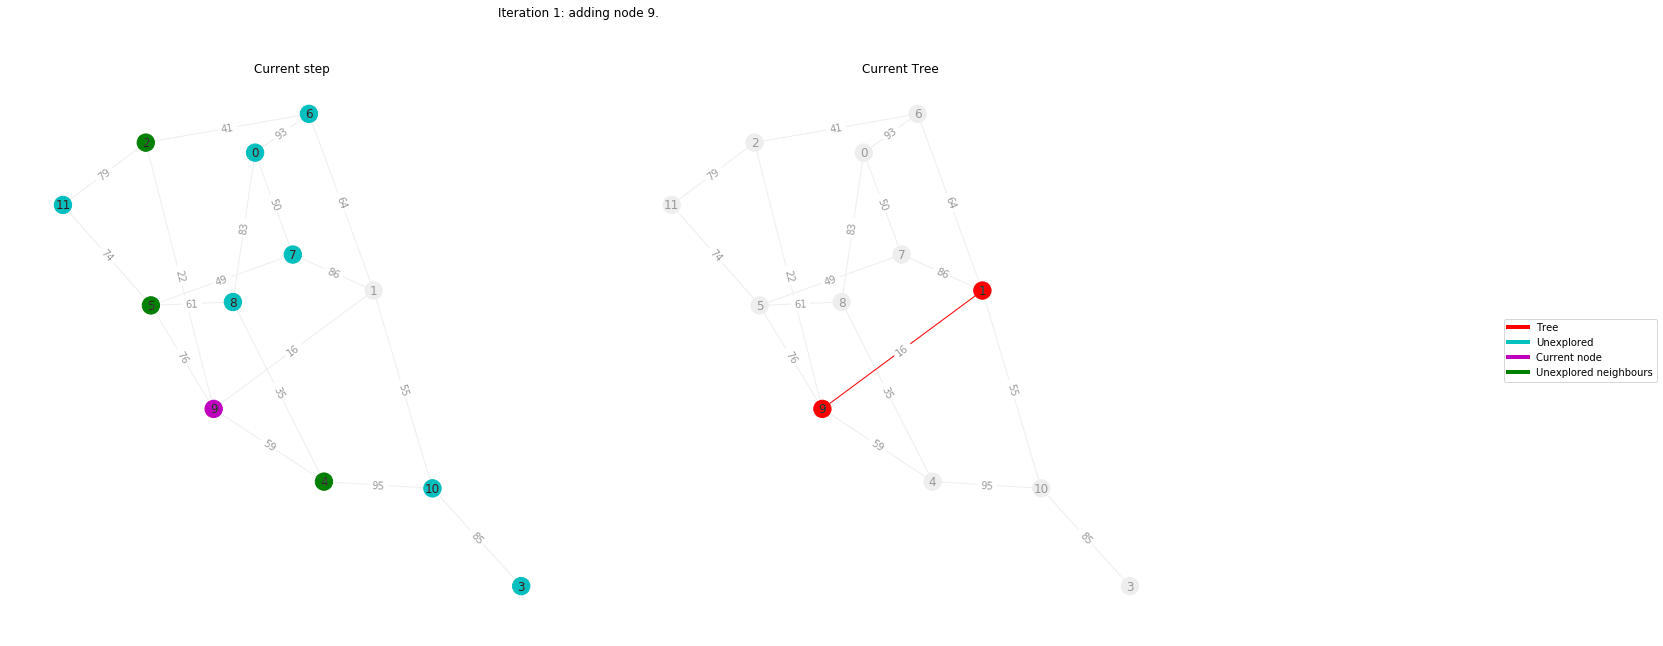

Current costs: {0: inf, 6: 64, 7: 86, 8: inf, 10: 55, 2: 22, 11: inf, 3: inf, 4: 59, 5: 76}


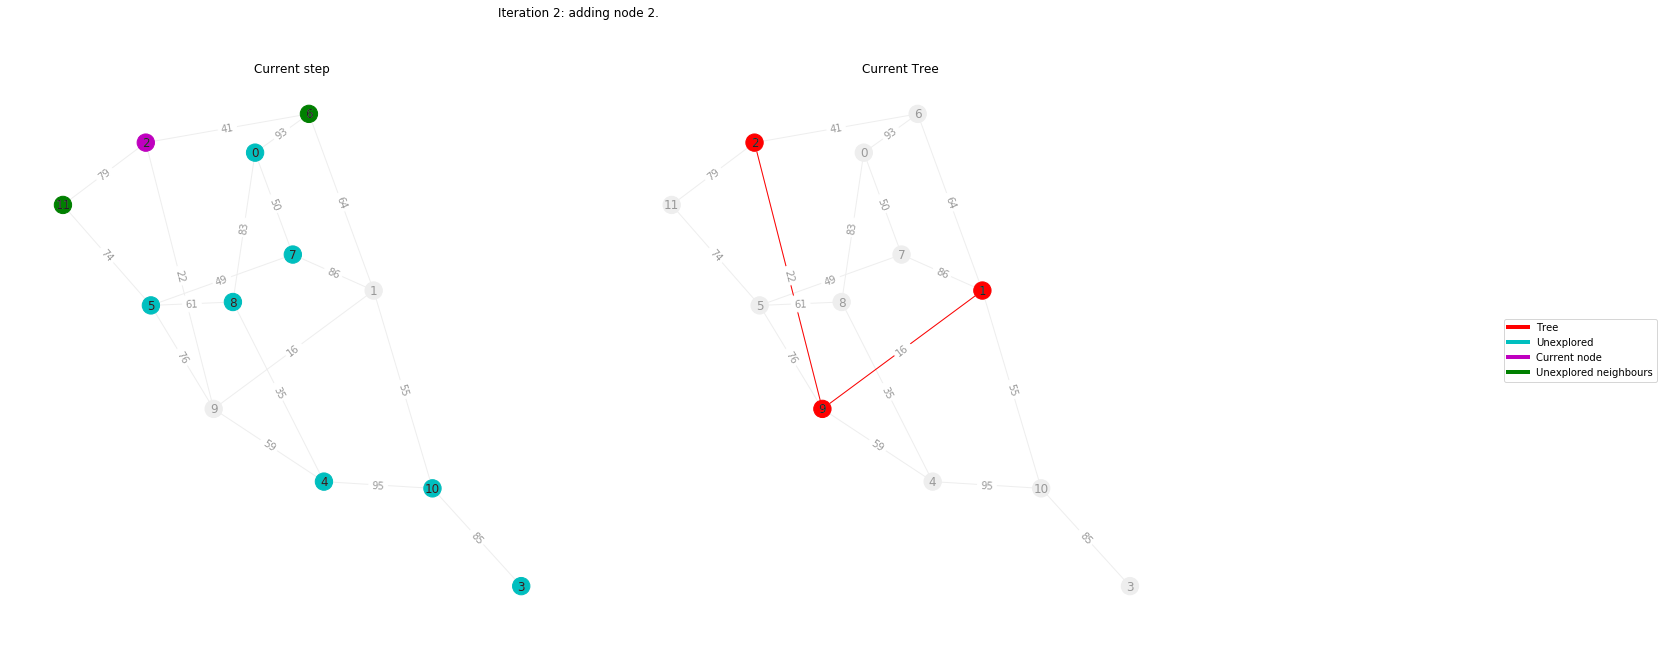

Current costs: {0: inf, 6: 41, 7: 86, 8: inf, 10: 55, 11: 79, 3: inf, 4: 59, 5: 76}


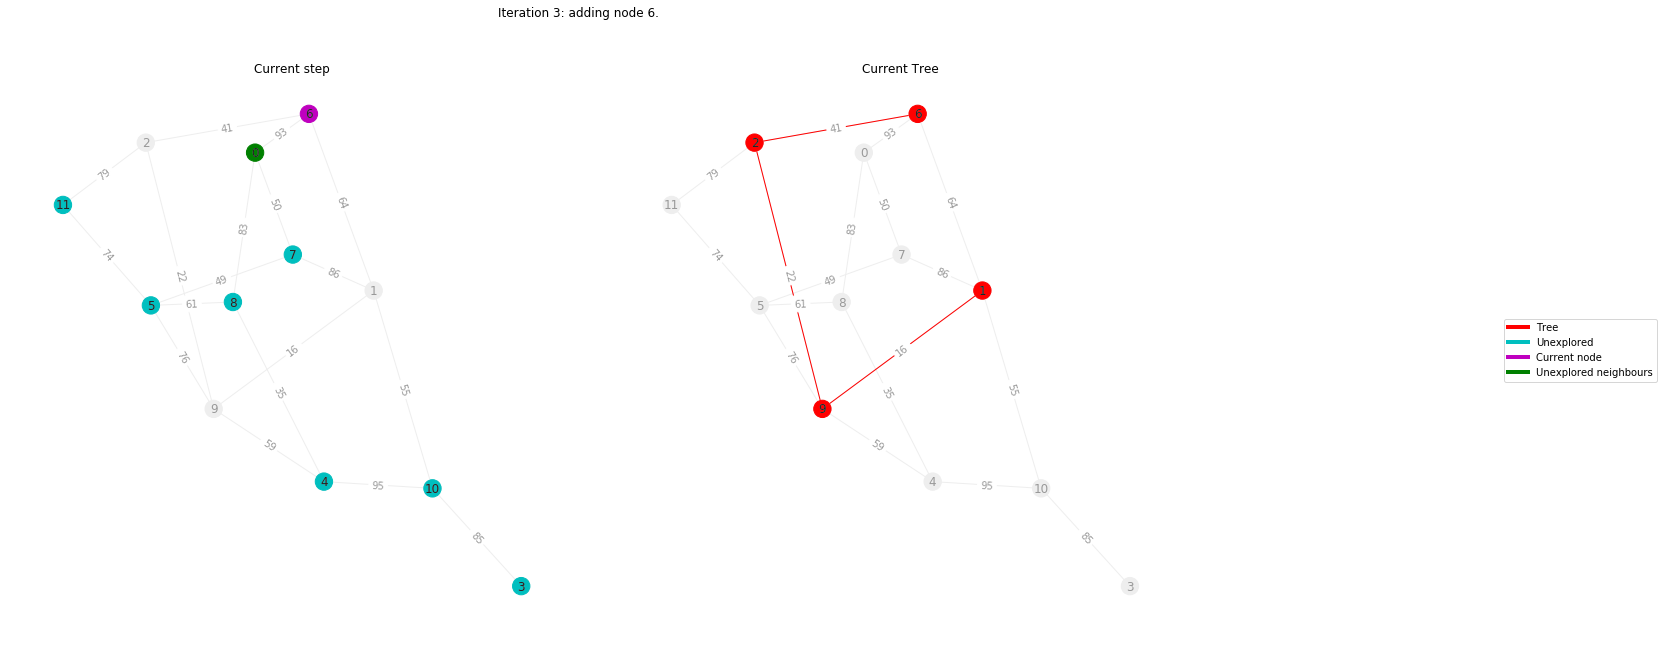

Current costs: {0: 93, 7: 86, 8: inf, 10: 55, 11: 79, 3: inf, 4: 59, 5: 76}


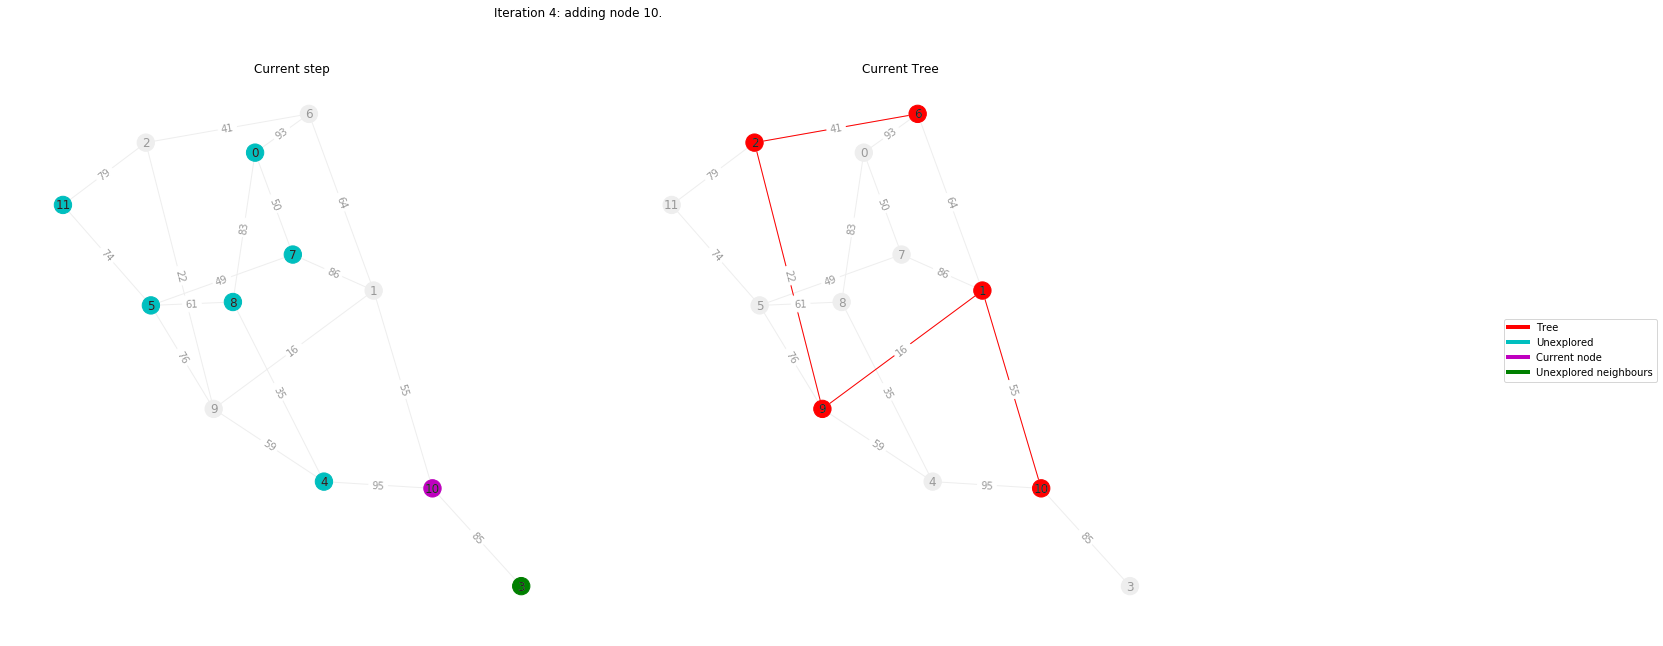

Current costs: {0: 93, 7: 86, 8: inf, 11: 79, 3: 85, 4: 59, 5: 76}


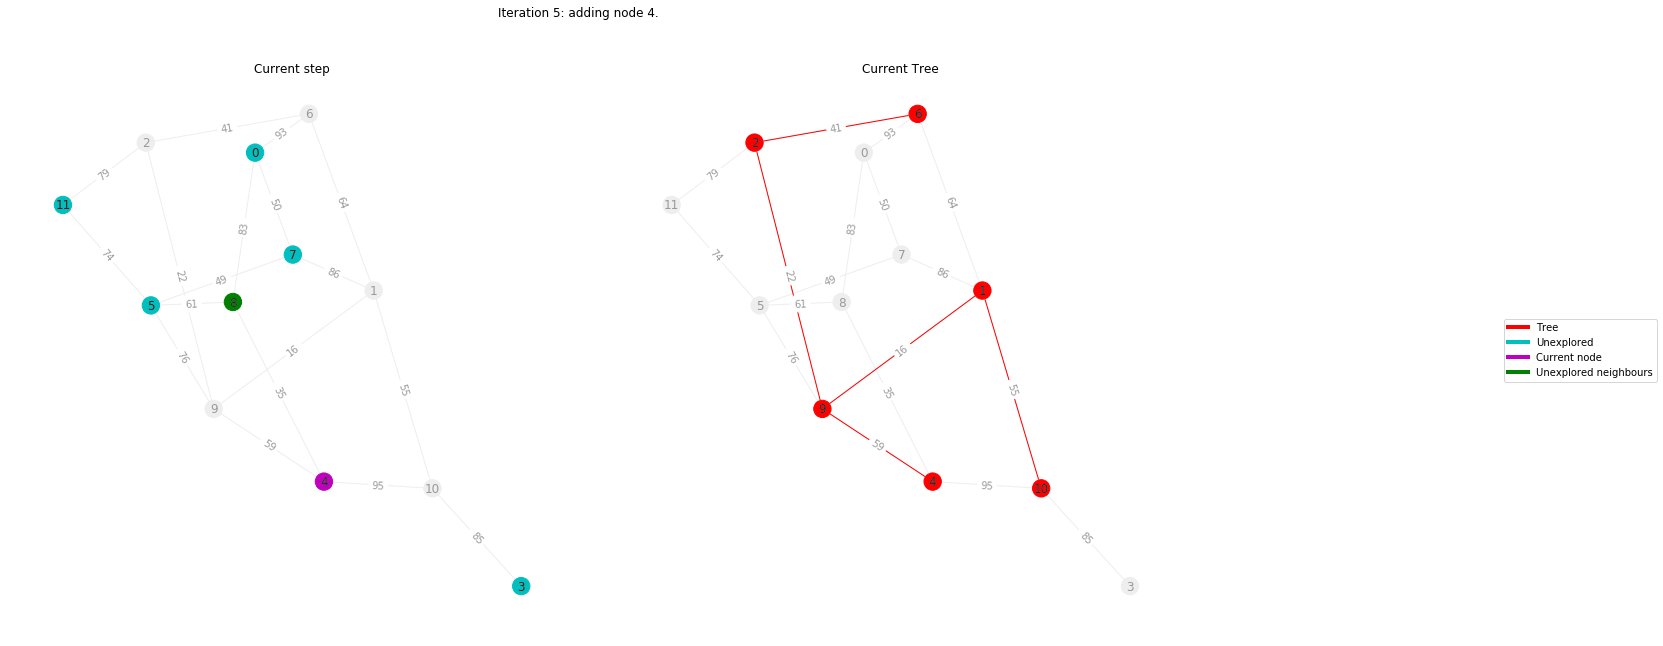

Current costs: {0: 93, 7: 86, 8: 35, 11: 79, 3: 85, 5: 76}


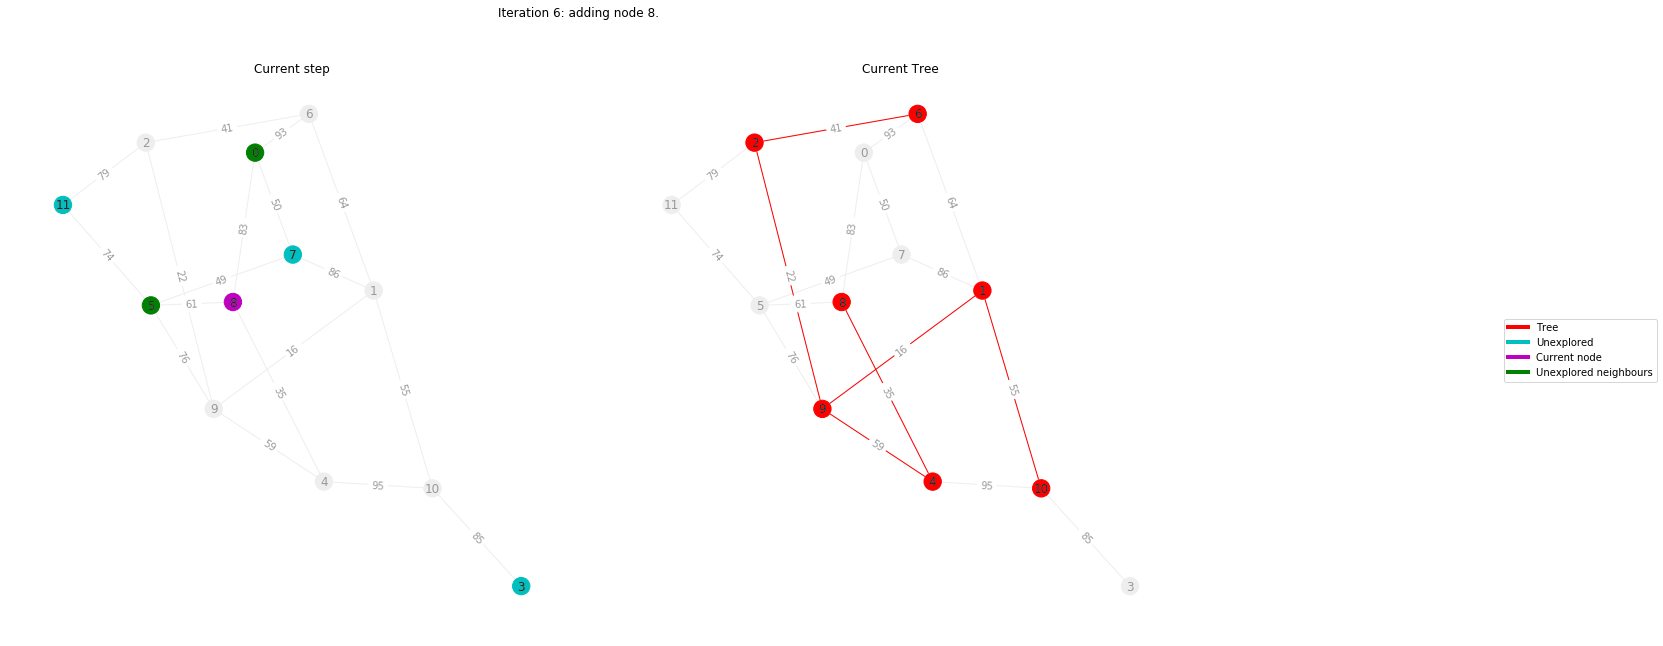

Current costs: {0: 83, 7: 86, 11: 79, 3: 85, 5: 61}


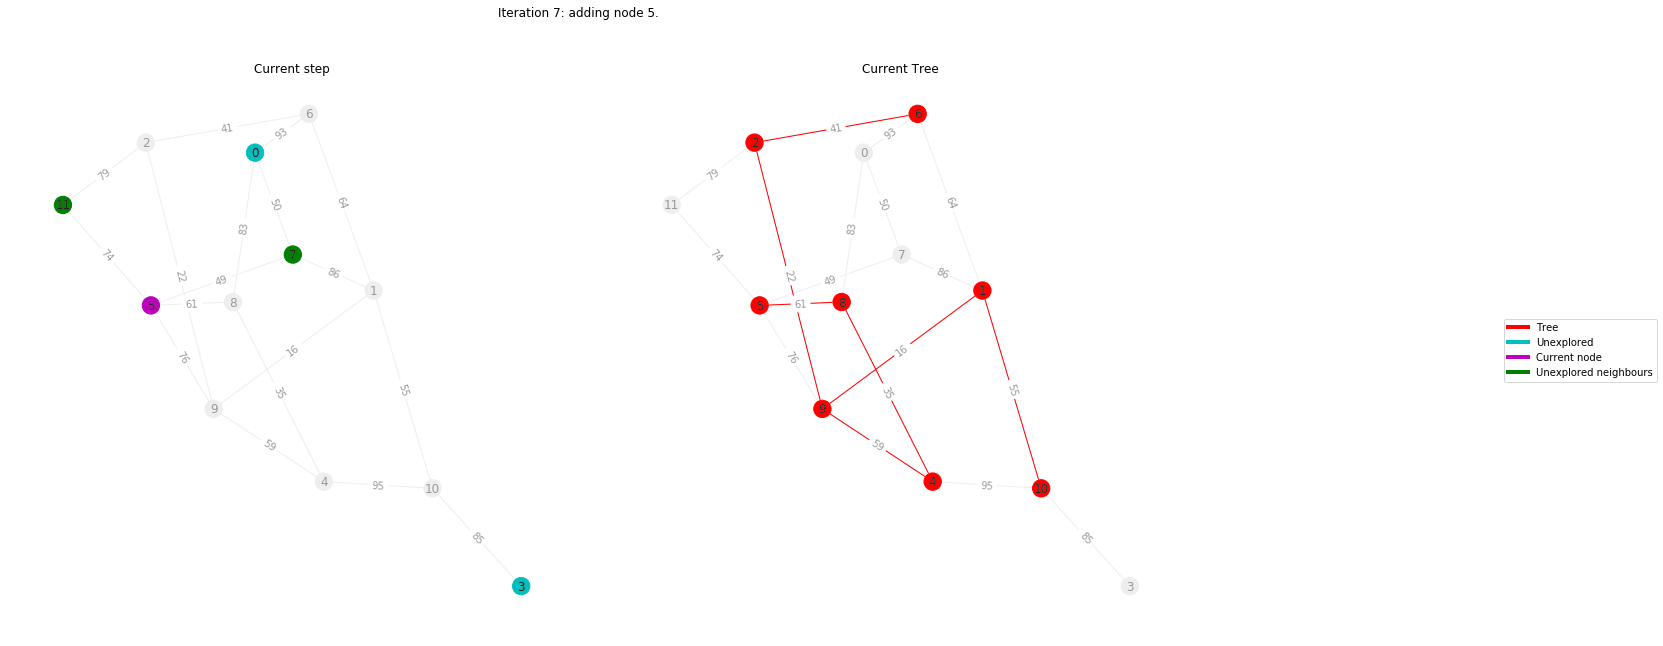

Current costs: {0: 83, 7: 49, 11: 74, 3: 85}


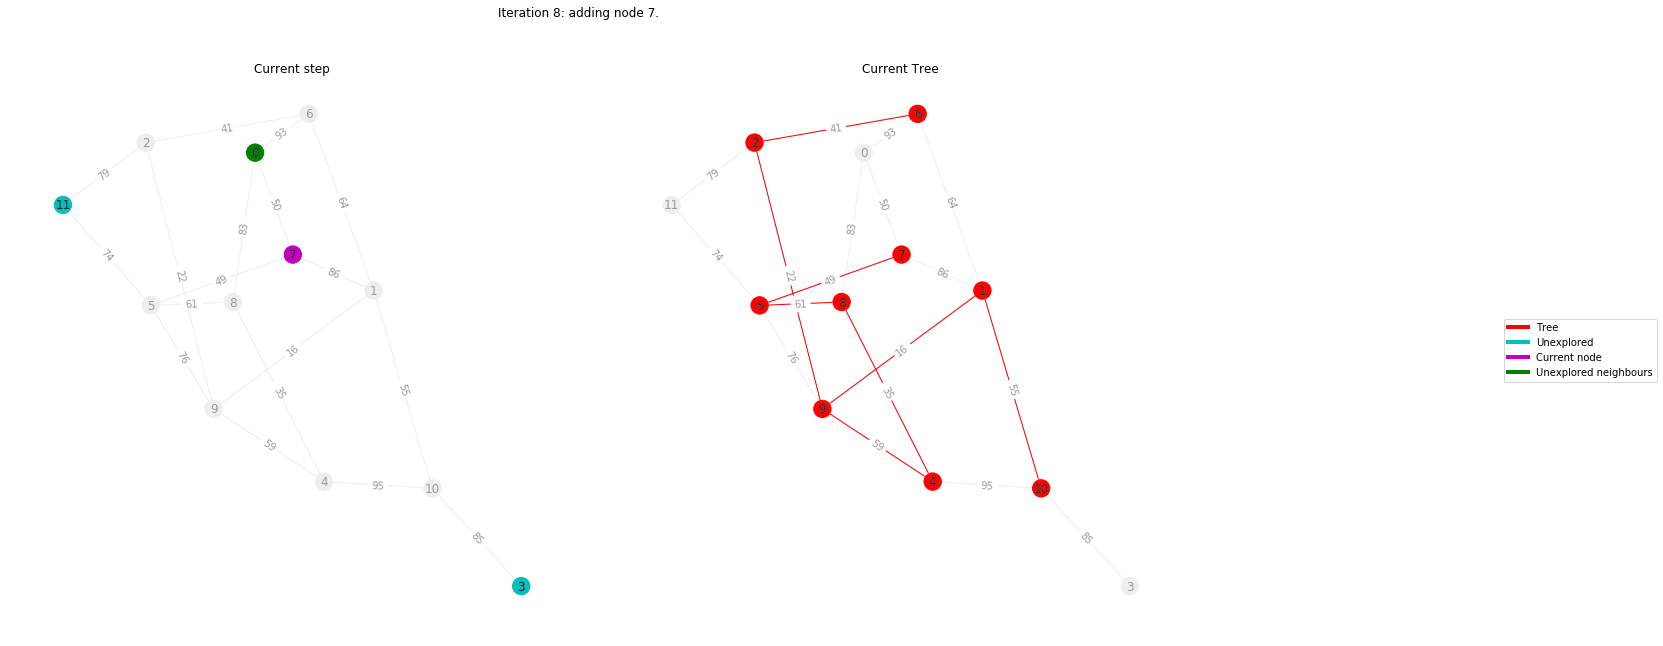

Current costs: {0: 50, 11: 74, 3: 85}


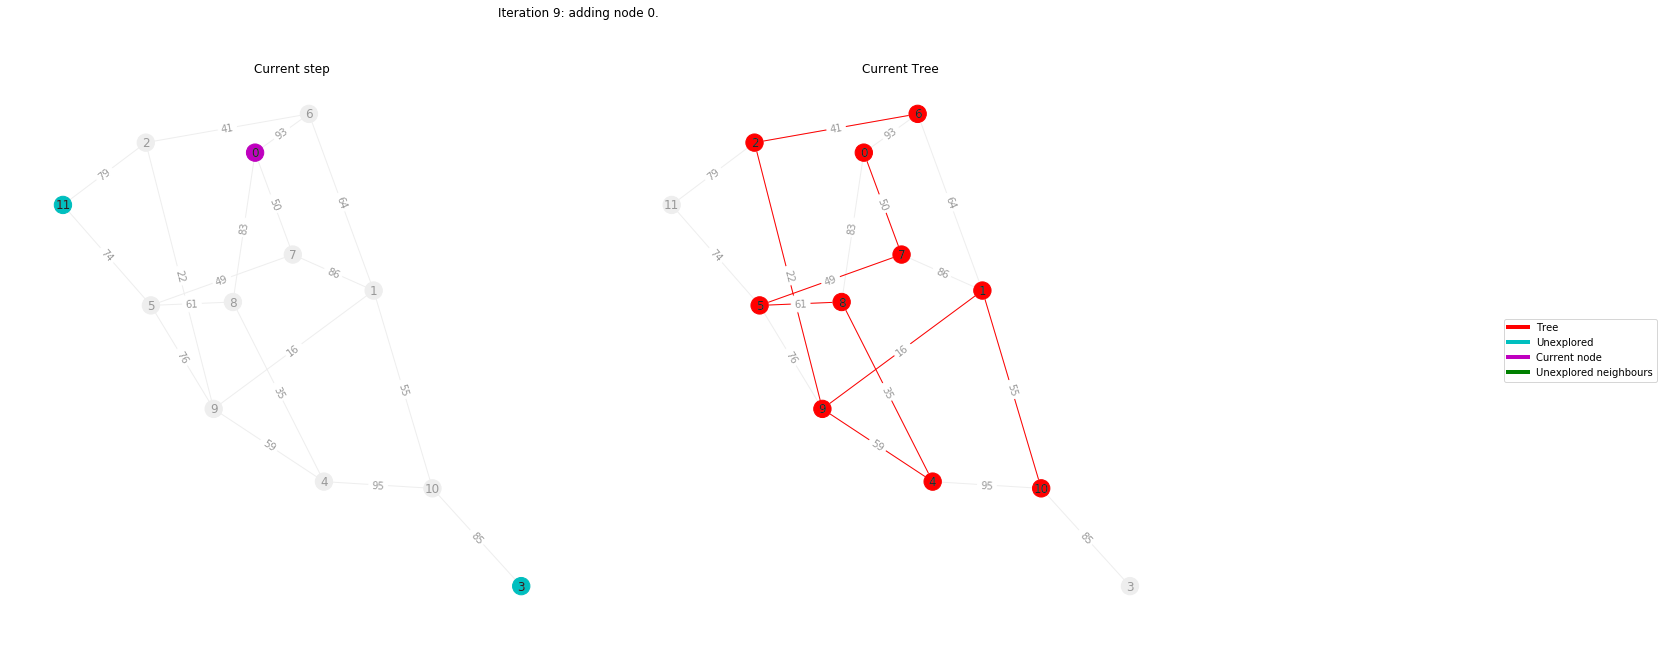

Current costs: {11: 74, 3: 85}


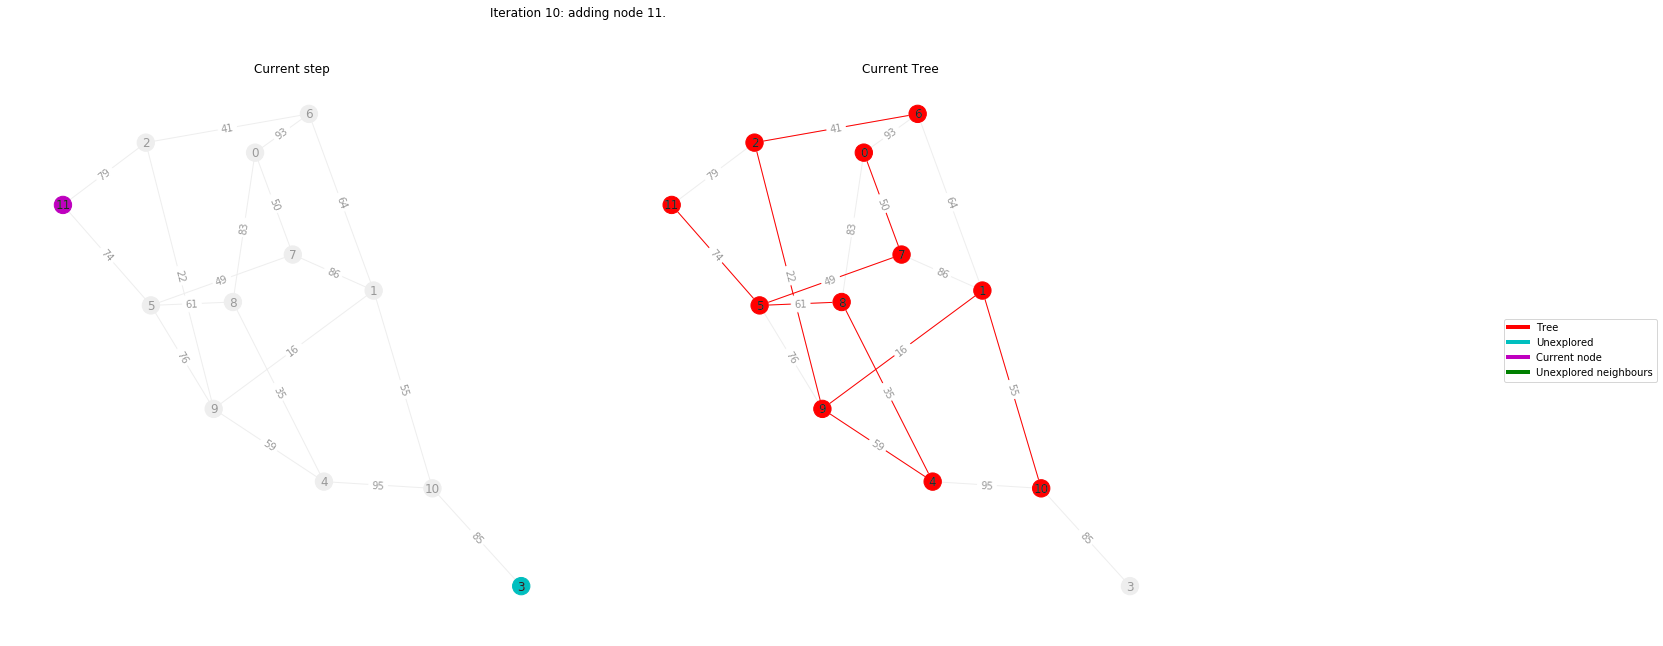

Current costs: {3: 85}


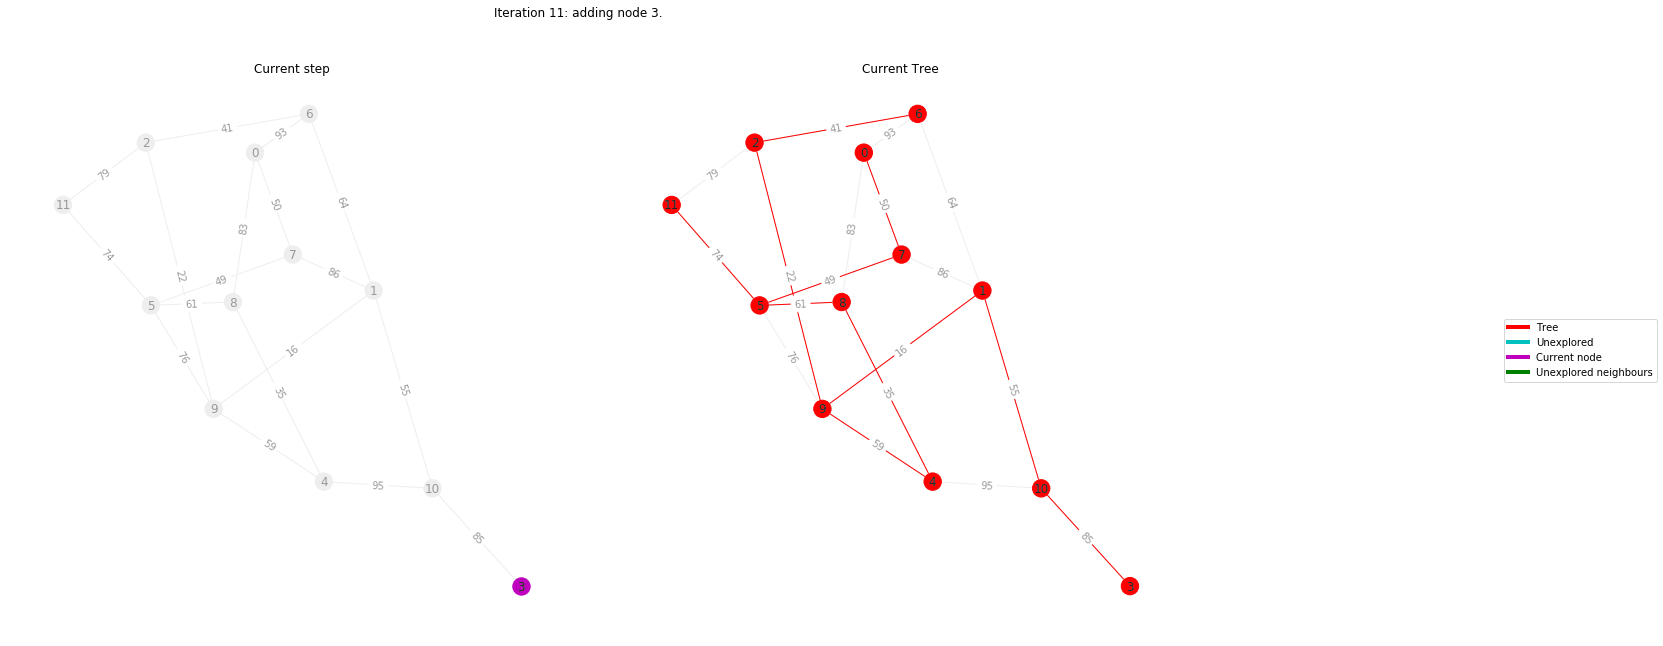

{1: 1, 9: 1, 2: 9, 6: 2, 10: 1, 4: 9, 8: 4, 5: 8, 7: 5, 0: 7, 11: 5, 3: 10}

In [26]:
PrimTree(G, root, describe=True)